# GPN Cup 2021
# Кирилл Захаров
#### Студент 4 курса прикладной математики и информатики в экономике и управлении СПбГЭУ
-------
## Содержание
1. [Импорт данных](#Импорт-данных)

2. [Рекомендательная система](#Рекомендательная-система)

    2.1. [Рекомендации по товару](#Рекомендации-по-товару)

    2.2. [Рекомендации по истории покупок клиента](#Рекомендации-по-истории-покупок-клиента)

3. [Формирование рекомендаций](#Формирование-рекомендаций)

4. [Заключение](#Заключение)


-------

# Импорт данных

#### Импорт библиотек

In [76]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#### Импорт транзакций

In [2]:
transactions = pd.read_parquet('transactions.parquet')

In [3]:
transactions.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002335,0.000000,3338297,0.147929,78634.0,102,2171-07-23
1,1158,0.002317,0.000000,3386107,0.134562,20900.0,101,2171-07-23
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23
4,1158,0.002355,0.000000,3257281,0.115023,67691.0,58,2171-07-23


In [4]:
len(transactions['client_id'].unique()) #Количество уникальных покупателей

370083

In [5]:
len(transactions['sku_id'].unique()) #Количество уникальных продуктов, которые покупали

4873

In [6]:
# список товаров у которых некорректные данные о количестве
products_with_a = transactions.loc[np.where((transactions['number']!= 0.0) & (transactions['litrs']!= 0.0))]['sku_id']

In [7]:
transactions.dtypes #иформация о типах данных

sku_id                int64
price               float64
number              float64
cheque_id             int64
litrs               float64
client_id           float64
shop_id               int64
date         datetime64[ns]
dtype: object

#### Посмотрим есть ли данные типа None

In [8]:
transactions.isna().any()

sku_id       False
price        False
number       False
cheque_id    False
litrs        False
client_id     True
shop_id      False
date         False
dtype: bool

In [9]:
indx = np.where(transactions['client_id'].isna())[0]

Поскольку пустые данные содержатся в столбце клиентов, а их тип данных float64, то заменим None на нули.

In [10]:
transactions['client_id'] = transactions['client_id'].replace(np.nan, 0) 

In [11]:
transactions.isna().any()

sku_id       False
price        False
number       False
cheque_id    False
litrs        False
client_id    False
shop_id      False
date         False
dtype: bool

#### Импорт таблицы с номенклатурой

In [12]:
nomenclature = pd.read_parquet('nomenclature.parquet')

In [13]:
nomenclature.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


#### Посмотрим на неизвестные данные

In [14]:
nomenclature.isna().sum() #есть некоторое количество полностью пустых данных, удалим их.

sku_id       0
full_name    9
brand        9
sku_group    0
OTM          9
units        9
country      9
dtype: int64

In [15]:
nomenclature.dropna(inplace=True)

In [16]:
nomenclature.isna().sum()

sku_id       0
full_name    0
brand        0
sku_group    0
OTM          0
units        0
country      0
dtype: int64

#### Объединим таблицы в одну. Для каждого значения таблицы transactions добавим описание товара из таблицы nomenclature, для этого склеим  по ключам слева.

In [17]:
data = pd.merge(transactions, nomenclature, how='left', on=['sku_id'])
data.dropna(inplace=True)

In [18]:
data.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт,unknown
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23,Сигареты Parker&Simpson duo purple,Parker&Simpson,Табачные изделия,Нет,шт,РОССИЯ
11,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ
12,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ
13,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ


In [19]:
data = data.drop(['date','country'], axis=1) #удаление даты и страны, так как дальше нигде не используются

In [20]:
data.shape

(5794703, 12)

#### Группы товаров для рекомендаций

In [21]:
groups = ['Вода', 'Сладкие Уранированные напитки, холодный чай', 'Кофейные напитки с молоком', \
          'Энергетические напитки', 'Снеки', 'Соки и сокосодержащие напитки']

In [22]:
data[data['sku_group'].isin(groups)].head() #посмотрим как вяглядят записи для данных групп

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group,OTM,units
38,199,0.011237,0.000452,2429861,0.104183,2937.0,78,Напиток Red Bull energy drink энергетический ж...,Red Bull,Энергетические напитки,Нет,л
46,3328,0.007132,0.000452,2108067,0.104183,128895.0,21,"Кофе Fly Cafe Моккачино 0,4л",Fly Cafe,Кофейные напитки с молоком,Нет,л
51,1551,0.005593,0.000452,3142853,0.104183,94533.0,56,unknown,unknown,Кофейные напитки с молоком,unknown,unknown
55,1551,0.005593,0.000452,2808683,0.104183,125076.0,17,unknown,unknown,Кофейные напитки с молоком,unknown,unknown
64,1551,0.005593,0.000452,2808595,0.104183,390043.0,17,unknown,unknown,Кофейные напитки с молоком,unknown,unknown


------
# Рекомендательная система

In [23]:
data['sku_id'] = data['sku_id'].astype(str) #поменяем тип данных товара на строчные для дальнейшей работы

In [24]:
customers = data['client_id'].unique().tolist() #создаем список с уникальными клиентами
len(customers)

369179

In [25]:
# customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

#### Формируем обучающую выборку

In [26]:
X_train = data #будем использовать все данные для обучения

In [27]:
X_train.head(2)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group,OTM,units
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,Сигареты Parker&Simpson duo purple,Parker&Simpson,Табачные изделия,Нет,шт


In [28]:
customers_train = X_train['client_id'].drop_duplicates().values #создаем список с уникальными клиентами

In [29]:
len(customers_train)

369179

#### Создадим массив истории покупок определенного товара для каждого клиента

In [30]:
purchases_train = list(X_train.groupby('client_id')['sku_id'].apply(list).to_dict().values())

In [31]:
# number_train = list(X_train.groupby('client_id')['number'].apply(list).to_dict().values())

In [32]:
# def join_subset(array1, array2):
#     array = array1
#     for i in range(len(array1)):
#         for j in range(len(array1[i])):
#             array[i][j] = array1[i][j] + ' ' + array2[i][j]    
            
#     return array

In [33]:
purchases_train[1:4]

[['1551', '1551'],
 ['218', '2884', '3125', '810', '1861', '1512'],
 ['997', '997', '2468', '2467', '3361']]

In [34]:
clients_keys = X_train['client_id'].value_counts().index.values # массив идентификаторов клиентов в порядке как в purchases_train

#### Построим модель Word2Vec для товаров.
В рамках данной модели на вход подается корпус слов, в нашем случае покупки клиентов. Затем модель создает словарь корпуса и вычисляет векторное представление слов. Таким образом на выходе мы получаем закодированные слова в виде векторов, между которыми будем далее измерять косинусное расстояние.

        1) window = 5            - ширина окна, т.е. максиальное расстояние от текущего до предсказанного слова 
                                    (эксперименты показали, что здесь лучше подходит число 5)
                                    
        2) sg = 1                - алгоритм обучения skip-gram (метод обратный CBOW, работает немного быстрее)
        
        3) hs = 0, negative = 15 - использование подхода отрицательной выборки. Идея в том, что будут изменяться не все веса, а
                                    только некоторые, тем самым происходит ускорение обучения
                                    
        4) alpha = 0.02          - начальная скорость обучения
        
        5) min_alpha = 0.0005    - минимальная скорость обучения до которой алгоритм опуститься
        
        6) seed = 5              - фиксированный seed для генерации случайных чисел
        
        7) epochs = 10           - число итераций по всему корпусу

In [35]:
# train word2vec model
model = Word2Vec(purchases_train, window = 2, vector_size = 50, sg = 1, hs = 0, negative = 10,
                 alpha = 0.05, min_alpha = 0.0005, seed = 5, epochs=5, compute_loss=True, min_count=0)

model.build_vocab(purchases_train)

model.train(purchases_train, total_examples = 1, epochs=5)

(10321667, 28973515)

In [36]:
model.get_latest_training_loss()

0.0

In [37]:
model.corpus_count

369179

In [38]:
# сохраним модель
model.save("word2vec_2.model")

In [39]:
# возьмем все вектора из корпуса
X = model.wv[model.wv.index_to_key]

X.shape

(4864, 50)

In [40]:
X_train['sku_id'].value_counts()

3329    129716
926     105297
3324     96884
269      78120
834      64544
         ...  
2399         1
2249         1
4620         1
623          1
4309         1
Name: sku_id, Length: 4864, dtype: int64

## Визуализация

Чтобы посмотреть как расположены товары определенных групп после преобразования моделью, применим метод главных компонент для понижения размерности.

In [41]:
pca = PCA(n_components=2, random_state=5)

In [42]:
x_reduction = pca.fit_transform(X)

In [43]:
x_reduction

array([[ 1.2120258 ,  1.2005903 ],
       [ 0.5741496 ,  1.6214619 ],
       [ 0.91765594,  1.3393885 ],
       ...,
       [-0.4656781 , -0.29436105],
       [-0.42403206, -0.3755358 ],
       [ 0.01582409, -0.4802534 ]], dtype=float32)

In [44]:
vocab = model.wv.index_to_key #словарь модели

In [45]:
X_dupl = X_train.drop_duplicates('sku_id') #удаляем все дупликаты, для визуализации

Сформируем массив colors, который будет отвечать за цвет определенной группы на позициях как в x_reduction.

In [46]:
colors = []
for i in tqdm.tqdm(vocab):
    for j in groups:
        if X_dupl[X_dupl['sku_id'] == i].iloc[0,9] == j:
            colors.append(groups.index(j))

100%|██████████| 4864/4864 [00:14<00:00, 338.16it/s]


In [47]:
colors = np.array(colors)

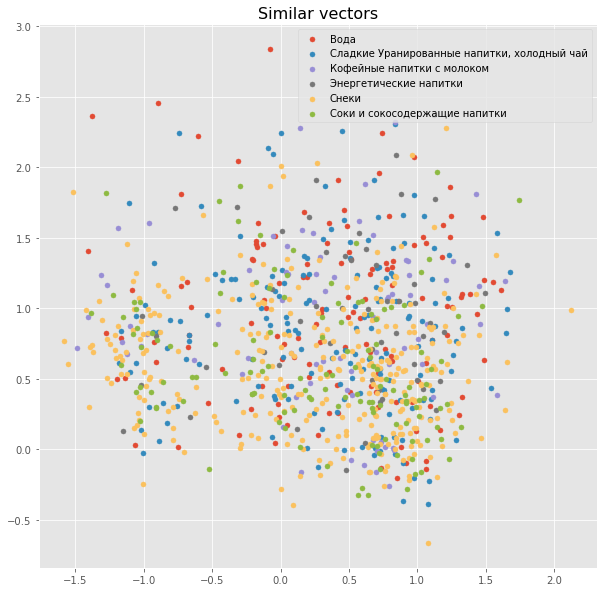

In [48]:
plt.subplots(figsize=(10, 10))

for i in range(len(groups)):
    
    var = x_reduction[np.where(colors == i)[0]]
    plt.scatter(var.T[0], var.T[1], label=groups[i], s=25)
    
plt.title("Similar vectors", fontsize=16)    
plt.legend()
plt.show()

На графике видно, как распределены товары определенных групп после преобразования в вектора.

#### Создание словаря товаров и их характеристик

In [49]:
# создадим датафрейм с интересующими нас признаками
products = X_train[['sku_id', 'sku_group', 'price', 'brand', 'full_name']]
products = products.copy()

# удаляем повторяющиеся товары
products.drop_duplicates(inplace=True, subset='sku_id', keep="last")

# создаем словарь продуктов с названиями товаров, брендом, ценой и группой товара
groups_dict = products.groupby('sku_id')['sku_group'].apply(list).to_dict()
price_dict = products.groupby('sku_id')['price'].apply(list).to_dict()
name_dict = products.groupby('sku_id')['full_name'].apply(list).to_dict()
brand_dict = products.groupby('sku_id')['brand'].apply(list).to_dict()
sku_dict = products.groupby('sku_id')['sku_id'].apply(list).to_dict()

In [50]:
# Объединение в один словарь
keys = groups_dict.keys()
values = zip(sku_dict.values(), groups_dict.values(), price_dict.values(),\
             name_dict.values(), brand_dict.values())

In [51]:
products_dict = dict(zip(keys, values))

## Рекомендации по товару

#### Функция для поиска похожих товаров
На вход подается вектор из словаря модели и число требуемых рекомендаций. Сначала отбираем все вектора, но уже упорядоченные по схожести, затем отбираем 20 лучших, которые принадлежат необходимым группам товаров, вычисляя косинусное расстояние между векторами.

In [52]:
def similar_products(v, n = 20):
    similar_products = model.wv.similar_by_vector(v, topn = len(products))[1:]
    
    recommend = [] #здесь будут храниться рекомендации
    k = 0 # счетчик для отбора только 20 лучших
    
    for i, product in enumerate(similar_products):
        if products_dict[product[0]][1][0] in groups and k != 20:
            recommend.append((products_dict[product[0]][0][0], products_dict[product[0]][3][0],\
                    products_dict[product[0]][1][0], products_dict[product[0]][4][0], \
                    products_dict[product[0]][2][0], product[1], k+1))
            k += 1
    return recommend

In [53]:
recommendations = similar_products(model.wv['3345'])

In [54]:
pd.DataFrame(recommendations, columns = ['sku_id', 'full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,983,Напиток G-Fly (СТМ) энергетический apple ж/б 0...,Энергетические напитки,G-Fly (СТМ),1.123653e-02,0.902324,1
1,2350,Попкорн PARTY TIME соль стакан 40г,Снеки,unknown,1.021036e-02,0.900560,2
2,1818,Чипсы Dr.Korner корнерсы кукурузно-рисовые том...,Снеки,Dr.Korner,5.079528e-03,0.899108,3
3,1959,"Чипсы Lay's лисички,сметана 85г",Снеки,Lay's,5.079528e-03,0.895059,4
4,4900,unknown,Кофейные напитки с молоком,unknown,1.400718e-02,0.893648,5
5,2459,"Вода Coconaut кокосовая 100% ж/б 0,32л",Соки и сокосодержащие напитки,unknown,5.592612e-03,0.893316,6
6,3142,unknown,Кофейные напитки с молоком,unknown,5.130836e-07,0.893116,7
7,4457,unknown,Кофейные напитки с молоком,unknown,1.015906e-02,0.892036,8
8,3275,Напиток Fly Cafe (СТМ) /G-Fly безалкогольный н...,"Сладкие Уранированные напитки, холодный чай",Fly Cafe (СТМ),5.592612e-03,0.890032,9
9,1441,"Батончик Energizer мюсли фрукты шоколад,мята 40г",Снеки,Energizer,5.900462e-03,0.884992,10


In [55]:
len(recommendations)

20

## Рекомендации по истории покупок клиента

При первом подходе, использовался только товар, что не дает полной картины относительно того, какой именно клиент это покупал. Истории покупок могут многое сказать о поведении покупателя, поэтому попробуем добавить данную модификацию в систему.

Берем конкретного клиента и смотрим на все товары которые он покупал. Далее смотрим для каждого товара его векторное представление и на выходе усредняем эти товары, получая некоторый один средний товар. Затем в модель передается этот усредненный вектор.

In [56]:
def history_aggregation(client_products):
    model_product = []
    
    for product in client_products:
        try:
            model_product.append(model.wv[product])
            
        except KeyError:
            continue
        
    return np.mean(model_product, axis=0)

#### Решение проблемы холодного старта.
Если в функцию client_history_fun передается клиент, которого нет в базе, то мы рассматриваем его как клиента 0, к которым относятся все покупатели без карты лояльности.

In [90]:
cl_keys_enum = list(enumerate(clients_keys))

In [125]:
def client_history_fun(client): #функция для поиска истории купленных товаров по id клиента
    temp = 0
    for i, clkey in cl_keys_enum:
        if clkey == client:
            temp = i
            break
    if temp == 0:
        return purchases_train[0]
    else:
        return purchases_train[temp]    
#     temp = np.where(clients_keys == client)[0]

#     if list(temp) == []: 
#         return purchases_train[0]
#     else: 
#         return purchases_train[temp[0]]

In [126]:
client_history = client_history_fun(103560.0)

In [127]:
recommendationsH = similar_products(history_aggregation(client_history));

Пример того, как выглядят рекомендации. Есть товары без полного наименования, возможно в дальнейшем их будет не удобно использовать продавцу, однако таких товаров довольно много и убирать все было бы не правильно. 

In [128]:
pd.DataFrame(recommendationsH, columns = ['sku_id','full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,1943,Напиток Laimon orange среднеУранированный ж/б ...,"Сладкие Уранированные напитки, холодный чай",Laimon orange,0.007440,0.751222,1
1,188,"Напиток Interkvass Kombucha имбирь,мед стекло ...","Сладкие Уранированные напитки, холодный чай",unknown,0.004053,0.673162,2
2,585,Напиток BONAQUA viva безалкогольный питьевая я...,Вода,BONAQUA,0.005080,0.665621,3
3,580,"Вода BONAQUA питьевая неУранированная ПЭТ 0,5л",Вода,BONAQUA,0.004361,0.655103,4
4,570,Смесь Fly Cafe (СТМ)/G-Fly ореховая соленая 100г,Снеки,Fly Cafe (СТМ),0.007132,0.644781,5
5,3141,"Вода Coconaut кокосовая сок ананаса ж/б 0,32л",Соки и сокосодержащие напитки,unknown,0.009184,0.643040,6
6,825,Напиток 28Seeds суперфуд безалкогольный неУран...,Соки и сокосодержащие напитки,unknown,0.005387,0.642019,7
7,443,Вода S.PELLEGRINO минеральная Уранированная ПЭ...,Вода,S.PELLEGRINO,0.007645,0.624081,8
8,1825,"Напиток sipep Уранированный wild cherry ПЭТ 0,5л","Сладкие Уранированные напитки, холодный чай",sipep,0.003540,0.619344,9
9,2438,unknown,Соки и сокосодержащие напитки,unknown,0.010210,0.615179,10


# Формирование рекомендаций

In [129]:
trans_subm = pd.read_parquet('transactions-for_submission.parquet')

In [130]:
trans_subm.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002304,0.000000,734259,0.142106,223748.0,42,2171-08-01 09:00:00
1,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
2,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
3,1158,0.002304,0.000000,734264,0.138006,NaN,42,2171-08-01 09:00:00
4,1534,0.002822,0.000452,734266,0.104183,NaN,42,2171-08-01 09:00:00


In [131]:
trans_subm['cheque_id'].value_counts()

3391059    41
2521683    32
1058916    31
2907515    31
2905380    30
           ..
856446      1
858495      1
1753476     1
1755525     1
1054717     1
Name: cheque_id, Length: 315228, dtype: int64

В файле есть дупликаты с одинаковыми чеками, товарами и клентом, чего не должно быть. Поэтому удалим их. Однако следует оставить те повторяющиеся чеки, в которых может быть несколько товаров.

In [132]:
trans_subm = trans_subm.drop_duplicates() #в файле есть дубликаты, удалим их

In [133]:
trans_subm['client_id'] = trans_subm['client_id'].replace(np.nan, 0)

In [138]:
submissions = trans_subm[['cheque_id', 'sku_id']].values
recs = []
for q, i in tqdm.tqdm(submissions): #проходимся по transactions-for_submission и генерируем рекомндации
    try:
        t = similar_products(model.wv[i])
        for j in t:
            recs.append([q, j[0], j[-1]])
    except KeyError:
        continue

100%|██████████| 525496/525496 [48:27<00:00, 180.74it/s]  


Модель, где используется история покупок клиентов, для всего файла transactions for submission считается слишком долго, поэтому в качестве файла submission-Захаров использовалась первая модель.

In [ ]:
# submissions = trans_subm[['cheque_id', 'sku_id', 'client_id']].values
# recs = []
# for q, i, client in tqdm.tqdm(submissions): #проходимся по transactions-for_submission и генерируем рекомндации
#     try:
#         t = similar_products(history_aggregation(client_history_fun(client)))
#         for j in t:
#             recs.append([q, j[0], j[-1]])
#     except KeyError:
#         continue

In [139]:
result = pd.DataFrame(recs, columns = ['cheque_id', 'sku_id', 'position'])

result['sku_id'] = result['sku_id'].astype(int) # так как в модели использовался строчный тип, то меняем обратно на int64

In [140]:
result.head(10)

,cheque_id,sku_id,position
0,734259,3889,1
1,734259,294,2
2,734259,2196,3
3,734259,1246,4
4,734259,319,5
5,734259,3710,6
6,734259,296,7
7,734259,4900,8
8,734259,1474,9
9,734259,1959,10


In [145]:
result.to_parquet('submission-Захаров.parquet') #запись в parquet

# Проверка результата

In [147]:
example = pd.read_parquet('submission-example.parquet')

In [148]:
pd.concat([result.iloc[:len(example)].drop('position', axis=1), example.drop('position', axis=1)], axis=1)

,cheque_id,sku_id,cheque_id,sku_id
0,734259,3889,734259,1499
1,734259,294,734259,1053
2,734259,2196,734259,1278
3,734259,1246,734259,3719
4,734259,319,734259,3292
5,734259,3710,734259,1951
6,734259,296,734259,3186
7,734259,4900,734259,3333
8,734259,1474,734259,2921
9,734259,1959,734259,2194


## Проверка на метрике Mean Average Precision at 20
(Далее пример вычисления метрик на двух чеках из примера)

In [149]:
def precision_atK(data1, data2, k):
    s = 0
    for i in range(k):
        if data1.iloc[i, 1] ==  data2.iloc[i, 1]:
            s += 1
    return s/k    

In [150]:
def apAtK(data1, data2, k):
    s = 0
    for i in range(k):
        if (data1.iloc[i, 1] ==  data2.iloc[i, 1]):
            s += precision_atK(data1, data2, i+1)
    
    return s/k

In [151]:
apAtK(result, example, 20)

0.0

In [152]:
def mapAtK(data1, data2, n):
    s = 0
    l = 0
    for i in range(n):
        s += apAtK(data1.iloc[l:(i+1)*20], data2.iloc[l:(i+1)*20], 20)
        l += 20
    return s/n

In [153]:
mapAtK(result, example, 2)

0.0

Метрики равны 0, так как здесь всего два чека и совпадений на них не обнаружено.

-----
# Заключение
Таким образом, была построена рекомендательная система для товаров из определенных групп. Модель основана на векторном представлении товаров и дальнейшем поиске близких векторов по косинусному расстоянию. Есть две вариации системы, в первой используется только товар, однако там показтель схожести ниже для конкретных клиентов, поэтому был предложен второй подход, основанный на усреднении всех покупок данного клиента.